# Training U-Net model with LandCoverNet dataset

- We'll attempt to include the 4th band (NDVI) included in the LandCoverNet datast
- The`segmentation_models_pytorch` library was used to load and specify the output for our Unet model.
- Replaced the first layer to accept 4 channels as input.
I included all the refrences that guide me through this task below.


# Installing Libraries and Downloading the data

In [ ]:
%%capture
!pip install fastai --upgrade
!pip install rasterio
!pip install segmentation-models-pytorch

In [ ]:
# Update the albumentations library
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ow91x7ii
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ow91x7ii
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=79946 sha256=274c100dc013cd8d9b1eb397de9546306a7a76a34adc78a4ddbae950a3348f94
  Stored in directory: /tmp/pip-ephem-wheel-cache-uryufuof/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!unzip "/content/drive/MyDrive/landcovernet_final_tif_NDVI.zip"

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from numpy import *
import numpy as np
import segmentation_models_pytorch as smp
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as BaseDataset
import albumentations as A

# Create Custom dataset
- The structure of the data is as follows:
Where each img sub folder contains the four bands and we have one target for each 4 img_sub folders, that were taken on different dates.
- root_dir:
  - inputs
    - 28QDE_00_20180103
      - 28QDE_00_20180103_B02_10m
      - 28QDE_00_20180103_B03_10m
      - 28QDE_00_20180103_B04_10m

      - 28QDE_00_20180103_NDVI_10m28QDE_00_20180***

    .

    .

    .
  - targets
    - 28QDE_00_2018_LC_10m
    - 28QDE_01_2018_LC_10m

    .

    .

    .


In [ ]:
# Hekper function to cisualize the images
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
      # Convert images to numpy and make it in shape for display
        
        
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
# Create custom dataset that accepts 4 channels images
from torch.utils.data import Dataset, DataLoader, sampler
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import rasterio as rio
from torchvision import transforms, datasets, models
# We have two dir: inputs(folder for each image) and tatgets
 
class LandCoverNetDataset(BaseDataset):
  
  CLASSES = ['otherland', 'cropland', 'pastureland', 'bare soil', 'openwater', 'forestland']
 
  def __init__(self, inputs_dir, targets_dir, 
               classes = None,  
               crossEntropy_target = False,
               preprocessing = False,
               augmentation=None,
               pytorch=True):
    
    super().__init__()
    self.samples = []
    self.pytorch = pytorch
    self.augmentation = augmentation
    self.preprocessing = preprocessing
    self.crossEntropy_target = crossEntropy_target
 
    # Convert str names to class values on masks
    self.class_value = [self.CLASSES.index(cls.lower()) for cls in classes]
 
    # Create dictionary for images and targets
    for sub_dir in os.listdir(inputs_dir):
      files = {}
      files = {
         'img_bands' : os.path.join(inputs_dir, sub_dir),
          'target' : os.path.join(targets_dir, sub_dir[:13] + "_LC_10m.png")
        }
      self.samples.append(files)
 
 
 
                                       
  def __len__(self):
    return len(self.samples)
  
  def normalize(self, band):
    
    #'''Notmalize a numpy array to have values between 0 and 1'''  
    band_min, band_max = band.min(), band.max()
    np.seterr(divide='ignore', invalid='ignore')
    normalized_band = ((band - band_min)/(band_max - band_min))
    #Remove any nan value and subtitute by zero
    where_are_NaNs = isnan(normalized_band)
    normalized_band[where_are_NaNs] = 0
    return normalized_band
 
 
  def open_as_array(self, idx, include_ndvi = False):
    '''
      Merge the 4 bands into one image and normalize the bands
    '''
    # List indivisual bands in each image folder
    # Stack them togather
    list_bands = []
    for img_file in os.listdir(self.samples[idx]['img_bands']):
      # Get the ndvi band
      if 'NDVI' in img_file:
        ndvi_band = os.path.join(self.samples[idx]['img_bands'], img_file)
      else:
        # Get the rgb bands
        band = rio.open(os.path.join(self.samples[idx]['img_bands'], img_file)).read(1)
        list_bands.append(band)
        # Stack the bands 
        raw_rgb = np.stack(list_bands, axis=2).astype('float32')
        
    
   
 
    if include_ndvi:
      # Include the NDVI band in the input images
      ndvi = np.expand_dims(rio.open(ndvi_band).read(1).astype('float32'), 2)
      raw_rgb = np.concatenate([raw_rgb, ndvi], axis=2)
 
    if self.augmentation:
      # Crop the image or perform other augmentations
      transformed = self.augmentation(image = raw_rgb)
      raw_rgb  = transformed["image"]
 
    if self.preprocessing:
      # transpose to tensor shape
      raw_rgb = raw_rgb.transpose((2,0,1)).astype('float32')
      # Convert to Tensor
      raw_rgb = torch.tensor(raw_rgb, dtype=torch.float)
       # Normalize the input bands
      for i in range(raw_rgb.shape[0]):
        raw_rgb[i, :, :] = self.normalize(raw_rgb[i, :, :])

    
    return raw_rgb
 
  def open_mask(self, idx):
    # Extract certain classes from mask
 
    mask = cv2.imread(self.samples[idx]['target'], 0).astype('int64')
    masks = [(mask == v) for v in self.class_value]
    mask = np.stack(masks, axis=-1).astype('int64')
 
    if self.augmentation:
      transformed = self.augmentation(image = mask)
      mask  = transformed["image"]
      
    if self.preprocessing:
      # Check if it is one hot
      if self.crossEntropy_target:
        mask = torch.argmax(torch.from_numpy(mask), dim=2)
        # Normalize the mask bands
        mask = self.normalize(mask)
        mask = torch.tensor(mask, dtype=torch.long)

      # process the one_hot target fpr diceloss
      else:
        # transpose to tensor shape
        mask = mask.transpose((2, 0, 1)).astype('float32') # mask shape [classes_channels, H, W]      
        # Normalize the mask bands
        for i in range(mask.shape[0]):
          mask[i, :, :] = self.normalize(mask[i, :, :])
        
        # Convert to Tensor
        mask = torch.from_numpy(mask)

    return mask
  
  def __getitem__(self, idx):
    x = self.open_as_array(idx, include_ndvi=True)
    y = self.open_mask(idx)
    
    
    return x, y
    
 
  def __repr__(self):
    s = 'Dataset class with {} files'.format(self.__len__())
    return s

(256, 256, 6)


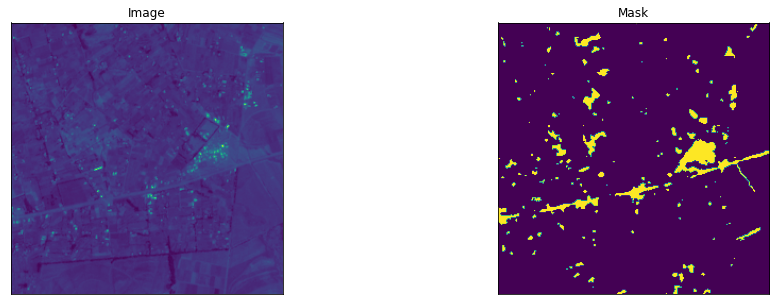

2512

In [ ]:
# Read the dataset
base_path = "/content/landcovernet_yes_baby"
CLASSES = ['otherland', 'Cropland', 'Pastureland', 'Bare soil', 'Openwater', 'Forestland']
 
data = LandCoverNetDataset(os.path.join(base_path, 'inputs'), 
                           os.path.join(base_path, 'targets'),
                           classes = CLASSES
                           )
 
x, y = data[2]
#y = y[:, :, 0]
print(y.shape)
visualize(image = x[:, :, 0],
          mask = y[:, :, 0],)
len(data)

In [ ]:
y.shape

(256, 256, 6)

In [ ]:
'''# plot the different mask segmentations
for i in range(y.shape[2]):
  mask = y[:, :, i]
  plt.imshow(mask)
  plt.show()'''

'# plot the different mask segmentations\nfor i in range(y.shape[2]):\n  mask = y[:, :, i]\n  plt.imshow(mask)\n  plt.show()'

## Create the Data Loader and Specify the Batches

In [ ]:
# Declare an augmentation pipeline

transform = A.Compose([
    A.CenterCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
 
 
])
 
def load_data(valid_split, batch_size, 
              transform = transform, preprocess=True):
    """Loads the data"""
    base_path = "/content/landcovernet_yes_baby"
    dataset = LandCoverNetDataset(os.path.join(base_path, 'inputs'), 
                           os.path.join(base_path, 'targets'), 
                           classes = CLASSES,
                           crossEntropy_target = False,
                           preprocessing=preprocess,
                           augmentation=transform)
 
 
    # Create indices for the split
    dataset_size = len(dataset)
    valid_size = int(valid_split * dataset_size)
    test_size = int(valid_split * dataset_size)
    train_size = dataset_size - (valid_size + test_size)
 
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset,
                                               [train_size, valid_size, test_size])
 
    train_loader = DataLoader(
        train_dataset.dataset,
        batch_size=batch_size,
        shuffle=True)
    valid_loader = DataLoader(
        valid_dataset.dataset,
        batch_size=batch_size,
        shuffle=True)
    
    test_loader = DataLoader(
        test_dataset.dataset,
        batch_size=batch_size,
        shuffle=True)
 
    return train_loader, valid_loader, test_loader
 
# Get our data loaders
train_loader, valid_loader, test_loader =  load_data(valid_split=0.15, batch_size=32, transform=transform, preprocess=True)

# Preparing our Model

Replace the model.conv1 to accept 4 channels

- first: copy the layer's weights
- assign them to the first three input channels

- assinitiate the fourth input channel wieghts with the weights of the first input channel 

In [ ]:

ENCODER = 'resnet101' #se_resnext50_32x4d  #Linknet
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' # softmax2d
DEVICE = 'cuda'
model = smp.Linknet(ENCODER, activation=ACTIVATION, classes=len(CLASSES), in_channels=4)


In [ ]:
# Check the data loader
images, masks = iter(train_loader).next()
print(images.shape)
print(masks.shape)
# Check the max value in our normalized image
print(images[0][0, :, :].max())
print(masks[0].dtype)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


torch.Size([32, 4, 224, 224])
torch.Size([32, 6, 224, 224])
tensor(1.)
torch.float32


In [ ]:
model

Linknet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [ ]:
# test our model 
x = torch.randn(8, 4, 224, 224)
output = model(x)
print(output.shape)

torch.Size([8, 6, 224, 224])


# Training our Model



In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
)

## Train Loop

In [ ]:
# Notes:
## Start with Adam and then SGD
### Have larger batch size
####

# train model for 40 epochs

max_score = 0
for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        
        print('Model saved!')
        
    '''if i == 30:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')'''

    if i == 45:
      torch.save({'model':model.state_dict(), 'optim':optimizer.state_dict()}, './best_model.pth')
      state_dict = torch.load('./best_model.pth')
      model.load_state_dict(state_dict['model'])
      optimizer = torch.optim.SGD(model.parameters(), 1e-5)


Epoch: 0
train:   0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


valid: 100%|██████████| 79/79 [00:50<00:00,  1.57it/s, dice_loss - 0.7204, iou_score - 0.1612]
Model saved!

Epoch: 1
valid: 100%|██████████| 79/79 [00:49<00:00,  1.58it/s, dice_loss - 0.6693, iou_score - 0.2404]
Model saved!

Epoch: 2
valid: 100%|██████████| 79/79 [00:50<00:00,  1.58it/s, dice_loss - 0.6309, iou_score - 0.2845]
Model saved!

Epoch: 3
valid: 100%|██████████| 79/79 [00:50<00:00,  1.57it/s, dice_loss - 0.5835, iou_score - 0.3409]
Model saved!

Epoch: 4
valid: 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, dice_loss - 0.5441, iou_score - 0.3579]
Model saved!

Epoch: 5
valid: 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, dice_loss - 0.5309, iou_score - 0.3653]
Model saved!

Epoch: 6
valid: 100%|██████████| 79/79 [00:49<00:00,  1.60it/s, dice_loss - 0.5032, iou_score - 0.3878]
Model saved!

Epoch: 7
valid: 100%|██████████| 79/79 [00:49<00:00,  1.60it/s, dice_loss - 0.4945, iou_score - 0.3845]

Epoch: 8
valid: 100%|██████████| 79/79 [00:49<00:00,  1.60it/s, dice_loss - 0.

#Test best saved model

In [ ]:
# load best saved checkpoint
model = torch.load('./best_model.pth')


In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|██████████| 314/314 [00:44<00:00,  6.99it/s, dice_loss - nan, iou_score - 2.491e-13]


#Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = (test_dataset[n][0]).numpy().astype('uint8')
    '''
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask[0, :, :]
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
'''
print(image_vis.shape)     
'''    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask[0,:,:]
    )'''

(4, 224, 224)


'    visualize(\n        image=image_vis, \n        ground_truth_mask=gt_mask, \n        predicted_mask=pr_mask[0,:,:]\n    )'

#Reference:
- https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
- https://medium.com/analytics-vidhya/how-to-create-a-custom-dataset-loader-in-pytorch-from-scratch-for-multi-band-satellite-images-c5924e908edf

- https://heartbeat.fritz.ai/image-segmentation-with-transfer-learning-pytorch-5ada7121c6ab

- https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

- https://github.com/albumentations-team/albumentations

- https://pypi.org/project/segmentation-models-pytorch/

Training best practice:
- https://towardsdatascience.com/a-big-of-tricks-for-image-classification-fec41eb28e01